The goal of this competition is to predict a Windows machine’s probability of getting infected by various families of malware, based on different properties of that machine. The telemetry data containing these properties and the machine infections was generated by combining heartbeat and threat reports collected by Microsoft's endpoint protection solution, Windows Defender.

Each row in this dataset corresponds to a machine, uniquely identified by a MachineIdentifier. HasDetections is the ground truth and indicates that Malware was detected on the machine. Using the information and labels in train.csv, you must predict the value for HasDetections for each machine in test.csv.

The sampling methodology used to create this dataset was designed to meet certain business constraints, both in regards to user privacy as well as the time period during which the machine was running. Malware detection is inherently a time-series problem, but it is made complicated by the introduction of new machines, machines that come online and offline, machines that receive patches, machines that receive new operating systems, etc. While the dataset provided here has been roughly split by time, the complications and sampling requirements mentioned above may mean you may see imperfect agreement between your cross validation, public, and private scores! Additionally, this dataset is not representative of Microsoft customers’ machines in the wild; it has been sampled to include a much larger proportion of malware machines.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from sklearn.experimental import enable_hist_gradient_boosting
import sklearn.ensemble as ske
from sklearn.model_selection import train_test_split
from sklearn import tree, linear_model
from sklearn.feature_selection import SelectFromModel
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics



In [2]:
# set up display area to show dataframe in jupyter qtconsole
#pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# We need to explicitly specify data types when reading csv, otherwise it is very memory consuming
# and we will get the warning "Specify dtype option on import or set low_memory=False"
# So, we will manually defined the data types

# P.S. I have loaded the sample data and exported train_data.dtypes
# these are the data types for fast loading

datatypes = {
    'ProductName': np.int8,
    'IsBeta': np.int8,
    'RtpStateBitfield': np.int64,
    'IsSxsPassiveMode': np.int8,
    'AVProductStatesIdentifier': np.int64,
    'AVProductsInstalled': np.int64,
    'AVProductsEnabled': np.int64,
    'CountryIdentifier': np.int64,
    'CityIdentifier': np.int64,
    'OrganizationIdentifier': np.int64,
    'GeoNameIdentifier': np.int64,
    'LocaleEnglishNameIdentifier': np.int64,
    'Platform': np.int16,
    'Processor': np.int8,
    'OsSuite': np.int64,
    'OsPlatformSubRelease': np.int16,
    'SkuEdition': np.int8,
    'IsProtected': np.int64,
    'AutoSampleOptIn': np.int8,
    'SMode': np.int64,
    'IeVerIdentifier': np.int64,
    'SmartScreen': np.int8,
    'Firewall': np.int64,
    'UacLuaenable': np.int64,
    'Census_MDC2FormFactor': np.int8,
    'Census_DeviceFamily': np.int8,
    'Census_OEMNameIdentifier': np.int64,
    'Census_ProcessorManufacturerIdentifier': np.int64,
    'Census_ProcessorModelIdentifier': np.int64,
    'Census_PrimaryDiskTotalCapacity': np.float64,
    'Census_PrimaryDiskTypeName': np.int8,
    'Census_SystemVolumeTotalCapacity': np.float64,
    'Census_HasOpticalDiskDrive': np.int8,
    'Census_TotalPhysicalRAM': np.float64,
    'Census_ChassisTypeName': np.int8,
    'Census_InternalPrimaryDiagonalDisplaySizeInInches': np.float64,
    'Census_InternalPrimaryDisplayResolutionHorizontal': np.int64,
    'Census_InternalPrimaryDisplayResolutionVertical': np.int64,
    'Census_PowerPlatformRoleName': np.int8,
    'Census_InternalBatteryNumberOfCharges': np.float64,
    'Census_OSArchitecture': np.int8,
    'Census_OSBranch': np.int8,
    'Census_OSBuildNumber': np.int64,
    'Census_OSBuildRevision': np.int64,
    'Census_OSEdition': np.int8,
    'Census_OSInstallTypeName': np.int8,
    'Census_OSInstallLanguageIdentifier': np.int64,
    'Census_OSUILocaleIdentifier': np.int64,
    'Census_OSWUAutoUpdateOptionsName': np.int8,
    'Census_IsPortableOperatingSystem': np.int8,
    'Census_GenuineStateName': np.int8,
    'Census_ActivationChannel': np.int8,
    'Census_IsFlightsDisabled': np.int64,
    'Census_FlightRing': np.int8,
    'Census_ThresholdOptIn': np.int64,
    'Census_FirmwareManufacturerIdentifier': np.int64,
    'Census_FirmwareVersionIdentifier': np.int64,
    'Census_IsSecureBootEnabled': np.int8,
    'Census_IsWIMBootEnabled': np.int64,
    'Census_IsVirtualDevice': np.int64,
    'Census_IsTouchEnabled': np.int8,
    'Census_IsPenCapable': np.int8,
    'Census_IsAlwaysOnAlwaysConnectedCapable': np.int64,
    'Wdft_IsGamer': np.int64,
    'Wdft_RegionIdentifier': np.int64,
    'EngineVersion_1': np.int64,
    'EngineVersion_2': np.int64,
    'EngineVersion_3': np.int64,
    'EngineVersion_4': np.int64,
    'AppVersion_1': np.int64,
    'AppVersion_2': np.int64,
    'AppVersion_3': np.int64,
    'AppVersion_4': np.int64,
    'AvSigVersion_1': np.int64,
    'AvSigVersion_2': np.float64,
    'AvSigVersion_3': np.int64,
    'AvSigVersion_4': np.int64,
    'OsVer_1': np.int64,
    'OsVer_2': np.int64,
    'OsVer_3': np.int64,
    'OsVer_4': np.int64,
    'OsBuildLab_1': np.int64,
    'OsBuildLab_2': np.int64,
    'OsBuildLab_3': np.int8,
    'OsBuildLab_4': np.int8,
    'OsBuildLab_5': np.int64,
    'OsBuildLab_6': np.int64,
    'Census_OSVersion_1': np.int64,
    'Census_OSVersion_2': np.int64,
    'Census_OSVersion_3': np.int64,
    'Census_OSVersion_4': np.int64,
    'CORE': np.int64,
    'EDUCATION': np.int64,
    'PRO': np.int64,
    'ENTERPRISE': np.int64,
    'CLOUD': np.int64,
    'SERVER': np.int64,
    'EVALUATION': np.int64,
    'ScreenProportion': np.float64,
    'ScreenDimensions': np.int64,
    'CapacityDifference': np.float64,
    'CapacityRatio': np.float64,
    'RAMByCores': np.float64,
    'HasDetections': np.int8
}

full_features = pd.read_csv('./csv/full_v11_engineered.csv', dtype=datatypes, index_col="MachineIdentifier")
full_labels = full_features["HasDetections"]

# Dropping labels ["HasDetections"] from training dataset
full_features = full_features.drop(["HasDetections"], axis=1)

In [4]:
print (full_features.shape)

(8921483, 103)


In [5]:
full_features.head(10)

,ProductName,IsBeta,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,Platform,Processor,OsSuite,OsPlatformSubRelease,SkuEdition,IsProtected,AutoSampleOptIn,SMode,IeVerIdentifier,SmartScreen,Firewall,UacLuaenable,Census_MDC2FormFactor,Census_DeviceFamily,Census_OEMNameIdentifier,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_PrimaryDiskTotalCapacity,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryNumberOfCharges,Census_OSArchitecture,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_IsPortableOperatingSystem,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightsDisabled,Census_FlightRing,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,EngineVersion_1,EngineVersion_2,EngineVersion_3,EngineVersion_4,AppVersion_1,AppVersion_2,AppVersion_3,AppVersion_4,AvSigVersion_1,AvSigVersion_2,AvSigVersion_3,AvSigVersion_4,OsVer_1,OsVer_2,OsVer_3,OsVer_4,OsBuildLab_1,OsBuildLab_2,OsBuildLab_3,OsBuildLab_4,OsBuildLab_5,OsBuildLab_6,Census_OSVersion_1,Census_OSVersion_2,Census_OSVersion_3,Census_OSVersion_4,CORE,EDUCATION,PRO,ENTERPRISE,CLOUD,SERVER,EVALUATION,ScreenProportion,ScreenDimensions,CapacityDifference,CapacityRatio,RAMByCores
MachineIdentifier,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
78c6e1235f17896ca611690f13c45274,1,0,7,0,53447,1,1,141,43526,-1,167,227,8,1,768,408,52,1,0,0,333,4,1,1,2,1,585,5,1985,953869.0,1,937940.0,0,4096.0,1,13.9,1366,768,1,-1.000000e+00,1,12,10586,420,1,3,9,34,3,0,1,1,-1,1,-1,556,63155,1,-1,0,0,0,0,0,10,1,1,14700,5,4,10,209,0,1,265.0,444,0,6,3,0,0,9600,19038,1,29,180608,1416,10,0,10586,420,0,0,0,0,0,0,0,1.778646,13660768,0.983301,-15929.0,2048.000000
eaa02aca61733a733ade919c1b703ec1,1,0,7,0,53447,1,1,171,140057,27,211,182,10,1,256,504,55,1,0,0,137,4,1,1,1,1,4589,5,3090,238475.0,2,237859.0,0,32768.0,2,27.2,1920,1080,2,4.294967e+09,1,24,17134,191,2,2,29,125,1,0,2,2,0,1,-1,142,3839,0,-1,0,0,0,0,1,3,1,1,15100,1,4,18,1807,18075,1,273.0,1208,0,10,0,0,0,17134,1,1,7,180410,1804,10,0,17134,191,0,0,0,0,0,0,0,1.777778,19201080,0.997417,-616.0,2730.666667
aa69d31f20a970c71a17d2f9ef0bc59c,1,0,7,0,53447,1,1,41,130775,27,52,217,10,1,768,503,52,1,0,0,111,4,1,1,2,1,4730,5,2321,715404.0,1,714789.0,0,4096.0,1,14.0,1366,768,1,0.000000e+00,1,23,16299,192,1,2,9,34,2,0,1,1,0,1,-1,897,4357,1,-1,0,0,0,0,0,10,1,1,15100,1,4,18,1807,18075,1,273.0,1296,0,10,0,0,0,16299,15,1,9,170928,1534,10,0,16299,192,0,0,0,0,0,0,0,1.778646,13660768,0.999140,-615.0,1024.000000
752eb9ae45914b38499aae5b7de7eb5e,1,0,7,0,53447,1,1,149,3167,-1,181,56,10,3,768,503,52,1,0,0,117,6,1,1,1,1,1443,5,1595,76293.0,3,75741.0,0,1024.0,5,20.1,1600,1200,5,4.294967e+09,3,23,16299,492,1,3,24,109,3,0,1,1,0,1,0,355,9375,0,0,0,0,0,0,0,15,1,1,15200,1,4,18,1807,18075,1,275.0,948,0,10,0,0,0,16299,15,3,9,170928,1534,10,0,16299,492,0,0,0,0,0,0,0,1.333333,16001200,0.992765,-552.0,512.000000
6d0e283ee387147327f10f402e8a7299,1,0,7,0,53447,1,1,21,17643,-1,192,74,10,1,768,503,52,1,0,0,111,6,1,1,2,1,2206,1,183,476940.0,1,453056.0,0,4096.0,1,15.5,1366,768,1,0.000000e+00,1,23,16299,248,1,3,8,31,3,0,1,1,0,1,0,554,33026,0,0,0,0,0,0,0,3,1,1,15100,1,4,18,1807,18075,1,273.0,1311,0,10

In [6]:
# Let's see some details of the loaded data
full_features.describe()

,ProductName,IsBeta,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,Platform,Processor,OsSuite,OsPlatformSubRelease,SkuEdition,IsProtected,AutoSampleOptIn,SMode,IeVerIdentifier,SmartScreen,Firewall,UacLuaenable,Census_MDC2FormFactor,Census_DeviceFamily,Census_OEMNameIdentifier,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_PrimaryDiskTotalCapacity,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryNumberOfCharges,Census_OSArchitecture,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_IsPortableOperatingSystem,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightsDisabled,Census_FlightRing,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,EngineVersion_1,EngineVersion_2,EngineVersion_3,EngineVersion_4,AppVersion_1,AppVersion_2,AppVersion_3,AppVersion_4,AvSigVersion_1,AvSigVersion_2,AvSigVersion_3,AvSigVersion_4,OsVer_1,OsVer_2,OsVer_3,OsVer_4,OsBuildLab_1,OsBuildLab_2,OsBuildLab_3,OsBuildLab_4,OsBuildLab_5,OsBuildLab_6,Census_OSVersion_1,Census_OSVersion_2,Census_OSVersion_3,Census_OSVersion_4,CORE,EDUCATION,PRO,ENTERPRISE,CLOUD,SERVER,EVALUATION,ScreenProportion,ScreenDimensions,CapacityDifference,CapacityRatio,RAMByCores
count,8.921483e+06,8.921483e+06,8.921483e+06,8.921483e+06,8.921483e+06,8.921483e+06,8.921483e+06,8.921483e+06,8.921483e+06,8.921483e+06,8.921483e+06,8.921483e+06,8.921483e+06,8.921483e+06,8.921483e+06,8.921483e+06,8.921483e+06,8.921483e+06,8.921483e+06,8.921483e+06,8.921483e+06,8.921483e+06,8.921483e+06,8.921483e+06,8.921483e+06,8.921483e+06,8.921483e+06,8.921483e+06,8.921483e+06,8.921483e+06,8.921483e+06,8.921483e+06,8.921483e+06,8.921483e+06,8.921483e+06,8.921483e+06,8.921483e+06,8.921483e+06,8.921483e+06,8.921483e+06,8.921483e+06,8.921483e+06,8.921483e+06,8.921483e+06,8.921483e+06,8.921483e+06,8.921483e+06,8.921483e+06,8.921483e+06,8.921483e+06,8.921483e+06,8.921483e+06,8.921483e+06,8.921483e+06,8.921483e+06,8.921483e+06,8.921483e+06,8.921483e+06,8.921483e+06,8.921483e+06,8.921483e+06,8.921483e+06,8.921483e+06,8.921483e+06,8.921483e+06,8921483.0,8921483.0,8.921483e+06,8.921483e+06,8921483.0,8.921483e+06,8.921483e+06,8.921483e+06,8.921483e+06,8.921483e+06,8.921483e+06,8921483.0,8.921483e+06,8.921483e+06,8.921483e+06,8.921483e+06,8.921483e+06,8.921483e+06,8.921483e+06,8.921483e+06,8.921483e+06,8.921483e+06,8.921483e+06,8.921483e+06,8.921483e+06,8.921483e+06,8921483.0,8921483.0,8921483.0,8921483.0,8921483.0,8921483.0,8921483.0,8.921483e+06,8.921483e+06,8.921483e+06,8.921483e+06,8.921483e+06
mean,1.010640e+00,7.509962e-06,6.816913e+00,1.733378e-02,4.764577e+04,1.317332e+00,1.012762e+00,1.080490e+02,7.830232e+04,1.688779e+01,1.696575e+02,1.228161e+02,1.315615e+01,1.182901e+00,5.751534e+02,4.770775e+02,5.263172e+01,9.377631e-01,2.891896e-05,-5.984184e-02,1.257338e+02,4.851331e+00,9.583232e-01,1.301069e+01,2.199818e+00,1.001615e+00,2.196395e+03,4.505936e+00,2.360278e+03,3.070696e+06,1.421740e+00,3.751264e+05,7.718728e-02,6.060050e+03,1.635429e+00,1.658281e+01,1.539560e+03,8.928383e+02,1.400344e+00,1.089928e+09,1.182800e+00,2.208815e+01,1.583483e+04,9.730490e+02,1.399004e+00,2.944290e+00,1.450525e+01,6.046534e+01,1.883548e+00,5.452008e-04,1.145705e+00,1.521135e+00,-

In [7]:
model = PCA(n_components=10)
pca_results = np.array(model.fit_transform(full_features))

# We need cumulative sums by components
variances = model.explained_variance_ratio_.cumsum()

for k in range(len(variances)):
    print ("k =", k + 1, " Variance =", variances[k])

k = 1  Variance = 0.9185561516932766
k = 2  Variance = 0.9999996613591835
k = 3  Variance = 0.9999999961987103
k = 4  Variance = 0.9999999999186915
k = 5  Variance = 0.9999999999778363
k = 6  Variance = 0.9999999999882623
k = 7  Variance = 0.9999999999930318
k = 8  Variance = 0.9999999999952992
k = 9  Variance = 0.9999999999972131
k = 10  Variance = 0.9999999999981479


In [8]:
# Shuffle the data
# np.random.seed(0)
shuffle = np.random.permutation(np.arange(full_features.shape[0]))

train_features, test_features, train_labels, test_labels = \
    train_test_split(full_features.values[shuffle], full_labels.values[shuffle], train_size=0.80)

print (train_features.shape, test_features.shape, train_labels.shape, test_labels.shape)

(7137186, 103) (1784297, 103) (7137186,) (1784297,)


In [9]:
scaler = StandardScaler()
scaler.fit(train_features)

normalized_train_features = scaler.transform(train_features)
normalized_test_features = scaler.transform(test_features)

In [10]:
# PCA = 2 gives us 0.999+ accuracy, but let's choose at least 10 for number of components
model = PCA(n_components=10)

train_pca = np.array(model.fit_transform(normalized_train_features))
test_pca = np.array(model.transform(normalized_test_features))

print (train_pca.shape, test_pca.shape)

(7137186, 10) (1784297, 10)


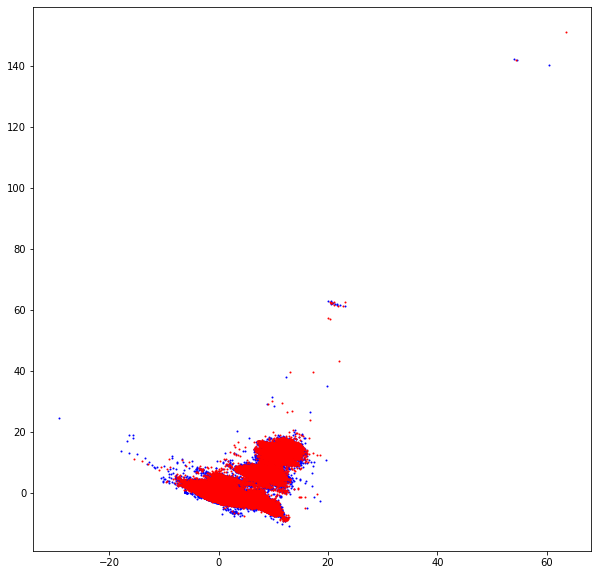

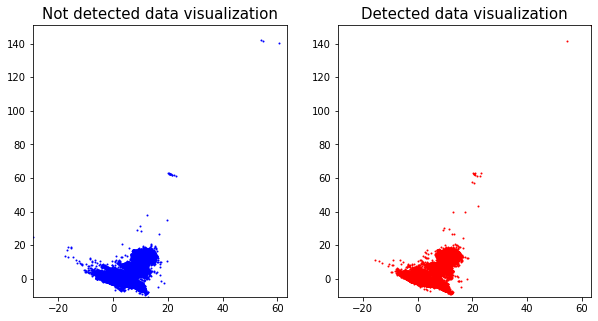

In [11]:
model = PCA(n_components=2)

train_pca_visual = np.array(model.fit_transform(normalized_train_features))

# when train_label == 1, then malware was detected
# when train_label == 0, malware was NOT detected

plt.figure(figsize=(10,10))

plt.plot(train_pca_visual[:,0][train_labels==0], train_pca_visual[:,1][train_labels==0], 'bo', markersize=1)
plt.plot(train_pca_visual[:,0][train_labels==1], train_pca_visual[:,1][train_labels==1], 'ro', markersize=1)


plt.figure(figsize=(10,5))
for i in range(2):
    color = 'bo' if i == 0 else 'ro'
    title = "Not detected data visualization" if i == 0 else "Detected data visualization"
    plt.subplot(1, 2, i + 1)
    plt.plot(train_pca_visual[:,0][train_labels==i], train_pca_visual[:,1][train_labels==i], color, markersize=1)
    plt.title(title, fontsize = 15)
    plt.ylim(train_pca_visual[:,1].min(), train_pca_visual[:,1].max())
    plt.xlim(train_pca_visual[:,0].min(), train_pca_visual[:,0].max())


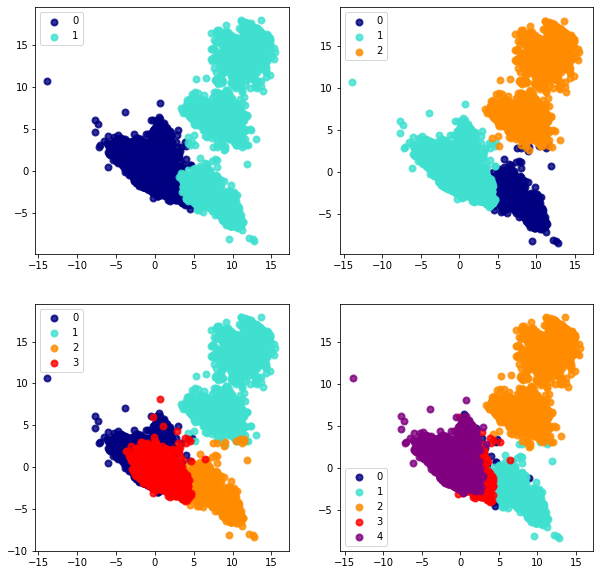

In [12]:
# Apply k-means + PCA + plot

from sklearn.cluster import KMeans

plot_data_length = 200000
colors = ['navy', 'turquoise', 'darkorange', 'red', 'purple', 'green', 'black']

fig, ax = plt.subplots(2,2,figsize=(10,10))

for k in range(2,6):
    # Fit the training data to a k-means clustering estimator model
    kmeans = KMeans(n_clusters=k).fit(train_pca[:plot_data_length])

    # Retrieve the labels assigned to each training sample
    kmeans_y = kmeans.labels_

    for color, cat in zip(colors, range(k)):
        p = ax[0 if k < 4 else 1,k % 2]
        p.scatter(train_pca[:plot_data_length][kmeans_y==cat, 0],
            train_pca[:plot_data_length][kmeans_y==cat, 1],
            color=color, alpha=.8, lw=2, label=cat)
        p.legend(loc='best', shadow=False, scatterpoints=1)


In [17]:
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

for s in solvers:
    # instantiate the model
    logreg = LogisticRegression(solver=s)

    # fit the model with data
    logreg.fit(train_pca, train_labels)

    # store the predicted response values
    y_pred = logreg.predict(test_pca)
    logreg_accuracy_score = accuracy_score(test_labels, y_pred)

    print('PCA = ', train_pca.shape[1], s, 'logreg_accuracy_score', logreg_accuracy_score)

/home/nn/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:426: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/home/nn/.local/lib/python3.6/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/nn/.local/lib/python3.6/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


PCA =  10 newton-cg logreg_accuracy_score 0.5642412670087995
PCA =  10 lbfgs logreg_accuracy_score 0.5642407065639857
PCA =  10 liblinear logreg_accuracy_score 0.5642418274536134


/home/nn/.local/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


PCA =  10 sag logreg_accuracy_score 0.5639094836790064


/home/nn/.local/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


PCA =  10 saga logreg_accuracy_score 0.5639061210101233


In [18]:
algorithms = {
    "HistGradientBoosting": ske.HistGradientBoostingClassifier(random_state=123),
    "DecisionTree": tree.DecisionTreeClassifier(max_depth=10,random_state=123),
    "RandomForest": ske.RandomForestClassifier(n_estimators=50,random_state=123),
    "GradientBoosting": ske.GradientBoostingClassifier(n_estimators=50,random_state=123),
    "AdaBoost": ske.AdaBoostClassifier(n_estimators=200,random_state=123),
}

In [ ]:
results = {}
print('Testing algorithms using original dataset...\n')
print()
for algo in algorithms:
    clf = algorithms[algo]
    clf.fit(train_features, train_labels)
    score = clf.score(test_features, test_labels)
    print("%s : %f %%" % (algo, score*100))
    results[algo] = score
    
winner = max(results, key=results.get)
print()
print(f'Winning algorithm is {winner} with a {results[winner]*100}% accuracy')

Testing algorithms using original dataset...


HistGradientBoosting : 64.357167 %
DecisionTree : 62.108943 %


In [ ]:
results = {}
print('Testing algorithms using normalized original dataset...\n')
print()
for algo in algorithms:
    clf = algorithms[algo]
    clf.fit(normalized_train_features, train_labels)
    score = clf.score(normalized_test_features, test_labels)
    print("%s : %f %%" % (algo, score*100))
    results[algo] = score
    
winner = max(results, key=results.get)
print()
print(f'Winning algorithm is {winner} with a {results[winner]*100}% accuracy')

In [ ]:
results = {}
print('Testing algorithms using PCA...\n')
print()
for algo in algorithms:
    clf = algorithms[algo]
    clf.fit(train_pca, train_labels)
    score = clf.score(test_pca, test_labels)
    print("%s : %f %%" % (algo, score*100))
    results[algo] = score
    
winner = max(results, key=results.get)
print()
print(f'Winning algorithm is {winner} with a {results[winner]*100}% accuracy')